# Gaze Estimation

In [1]:
#Basic
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

#Aiding conversions from string to list
import ast

#Randomize
import random

#Labelling classifiers
import datetime
import joblib

#Support Vector Classification
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from joblib import dump, load
from sklearn.model_selection import GridSearchCV
from sklearn import svm
#Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pandas import DataFrame
import seaborn as sns

## 1. Recording a video

Just record it. Falar de algumas precauções e cuidades. IDK

## 2. Converting the video in measurable data / Data treatment

### 2.1 Importing the text file

To do so, we created [datasetGenerating.py](https://github.com/antonioramiro/gaze-estimation/blob/master/datasetGenerating.py) which converts a video into an array of (~) 47 elements. yada yada yada

``demo da datasetGenerating`` .gif e o comando q se usa 

Then, to cluster every vector generated, each in an individual .txt file, we used [txtJoiner](https://github.com/antonioramiro/gaze-estimation/blob/master/txtJoiner.py), which outputs the following file yada yada. When said file is imported, the lines are read as strings, therefore it needs to be converted to a list of lists.

In [2]:
#opening the file
with open('dataset_2020-06-07.txt') as file:
    txt_file = [line.strip() for line in file]

dataset = []
#converting a list of strings to a list of lists
counter = 0
total_lines = len(txt_file)
while counter != total_lines:
    individual_line = ast.literal_eval(txt_file[counter])
    dataset += [individual_line]
    counter+=1

#### 2.1.1 Understanding the data

meter aqui imagem do boneco, com a legenda adequada ao nosso vetor. como por aquilo bonito? fica melhor explicado por escrito do que tudo discriminado.

``[x_nose, y_nose, x_neck, y_neck, x_right ear, y_right ear, x_left ear, y_left ear, x_right eye, y_right eye, x_left eye, y_left eye, x_right hand, y_right hand, x_left hand, y_left hand, ... contextual information - 32 positions ..., quadrant]``

### 2.2 Separating data for testing and for training

Now let's get the party going. Separate data

In [3]:
testing_data = dataset[int(len(dataset)*0.8):]
training_data = dataset[:int(len(dataset)*0.8)]

### 2.2 Increasing sample size

inverter horizontalmente as cenas + termos o dobro dos dados. nota: a geradora do dataset cospe a resolução das imagens na sua penúltima linha

In [5]:
print('Initially, the training dataset is composed by ' + str(len(training_data)) + ' elements.')

Initially, the training dataset is composed by 8205 elements.


In [6]:
def dataDoubler(dataset):
    resolution = (640,352) 
    flipped_dataset = []

# Calculate the simetric quadrant, where the input is an int and the output is a list of 1 element.
# Given the numeration of quadrants (stated in 2.1.1), a simple addition/subtraction of 3 or 5 will yield
# the simetric quadrant

    def flipped_quadrant(quadrant):
        if quadrant in [1,3,9,11]:
            flipped_quadrant = quadrant + 3 
        elif quadrant in [4,6,12,14]:
            flipped_quadrant = quadrant - 3 
        elif quadrant in [0,2,8,10]:
            flipped_quadrant = quadrant + 5
        elif quadrant in [5,7,13,15]:
            flipped_quadrant = quadrant - 5  
        return [flipped_quadrant]

    def flip_shortlong(bigList):
        if len(bigList) != 32:
            print(bigList)
            print(len(bigList))
            return 'auch'
        else:
            newList=[bigList[5],bigList[4],bigList[7],bigList[6],bigList[1],bigList[0],bigList[3],bigList[2],\
                 bigList[13],bigList[12],bigList[15],bigList[14],bigList[9],bigList[8],bigList[11],bigList[10],\
                 bigList[16+5],bigList[16+4],bigList[16+7],bigList[16+6],bigList[16+1],bigList[16+0],bigList[16+3],bigList[16+2],\
                 bigList[16+13],bigList[16+12],bigList[16+15],bigList[16+14],bigList[16+9],bigList[16+8],bigList[16+11],bigList[16+10]]
            return newList
    
    for element in dataset:
        flipped_element = []
        for i in range(len(element) - 33):

            # Every even index (up to the 14th: indexes that correspond to coordinates of poseKeypoints) contains 
            # an X coordinate, from which can be obtained the simetric coordinate (by subtracting to the width
            # the original X), note that Y is irrelevant to horizontal simetry.

            if i%2 == 0 and element[i] != -1: 
                flipped_element += [resolution[0] - element[i]]

            else: #y or x == -1
                flipped_element += [element[i]]       

        flipped_dataset += [flipped_element + flip_shortlong(element[16:-1])  + flipped_quadrant(element[-1])]

    dataset += flipped_dataset
    return dataset

In [7]:
training_data = dataDoubler(training_data)
testing_data = dataDoubler(testing_data)

In [8]:
print('Now, it has ' + str(len(training_data)) + ' elements.')

Now, it has 16410 elements.


In [9]:
print(dataset[0])
print(len(dataset[0]))

[432.83353, 156.35634, 502.60385, 225.26476, -1, -1, 462.41827, 162.12698, -1, -1, 438.50482, 148.76007, -1, -1, 410.79236, 349.59262, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 9]
49


In [10]:
a = 0
b = 0
c = []
for i in training_data:
    if len(i) == 49:
        a += 1
    elif len(i) == 51:
        b += 1
        
    else: c+= [i]

a,b,c

(16410, 0, [])

### 2.2.1 Feature Engineering

In [11]:
def head_angle(x_nose,y_nose,x_neck,y_neck):
    #angle() calculates the angle at which the head is tilted using the coordinates of the nose and neck
    if x_nose>=0 and x_neck>=0:
        x=abs(x_nose-x_neck)
        y=abs(y_nose-y_neck)
        angle=math.atan(y/x)
        if x_nose-x_neck<0:
            angle+=math.pi/2
        return [int(angle)]
    else:
        return [-1]

    
def hand_distance(x_rhand,y_rhand,x_lhand,y_lhand,x_nose,y_nose):
    #hand_distance() calculates the distance between the hands and the face using the nose coordinates
    right=-1
    left=-1
    if x_rhand>=0 and x_nose>=0:
        right=math.sqrt((x_rhand-x_nose)**2+(y_rhand-y_nose)**2)
        
    if x_lhand>=0 and x_nose>=0:
        left=math.sqrt((x_lhand-x_nose)**2+(y_lhand-y_nose)**2)
    
    distances=[int(right),int(left)]
    return distances


def hand_angles(x_rhand,y_rhand,x_lhand,y_lhand,x_neck,y_neck):
    #hand_angles() calculates the angle between each arm and the horizontal axis
    r_angle=-1
    l_angle=-1
    if x_rhand>=0 and x_neck>=0:
        x=abs(x_rhand-x_neck)
        y=abs(y_rhand-y_neck)
        r_angle=math.atan(y/x)
    if x_lhand>=0 and x_neck>=0:
        x=abs(x_lhand-x_neck)
        y=abs(y_lhand-y_neck)
        l_angle=math.atan(y/x)
        
    angles=[int(r_angle),int(l_angle)]
    return angles

In [12]:
def addFeature(dataset):
    dataset = [i[:-1] + head_angle(i[0],i[1],i[2],i[3]) + hand_distance(i[12],i[13],i[14],i[15],i[0],i[1]) + hand_angles(i[12],i[13],i[14],i[15],i[2],i[3]) + [i[-1]] for i in dataset]
    return dataset

``[x_nose, y_nose, x_neck, y_neck, x_right ear, y_right ear, x_left ear, y_left ear, x_right eye, y_right eye, x_left eye, y_left eye, x_right hand, y_right hand, x_left hand, y_left hand, ... contextual information - 32 positions ..., head angle, distance from head to hand x & y, distance from hands x & y , quadrant]``

In [13]:
training_data = addFeature(training_data)
testing_data = addFeature(testing_data)

### 2.2.2 Leveling the data - corrigir numeracao

Em vez de leveling, outra palavra para descrever este processo de fazer os numeros mais proximos.  Due to XXXX, some quadrants tend to be more prevalent. So in order not to confuse :p the SVM, the values should be more homogenized  Falar um pouco

Firstly lets visualise the distributtion of data with the following function

In [14]:
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import random
%matplotlib inline

def heatmap (dataset):
    #in the quadrant_count list, each number corresponds to the number of samples where the object is in that
    #quadrant so quadrant_count[0] is the number of samples in the 0 quadrant
    quadrant_count=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for i in range(len(dataset)):
        quad=dataset[i][-1]
        quadrant_count[quad]=quadrant_count[quad]+1
    data=[[quadrant_count[0],quadrant_count[1],quadrant_count[4],quadrant_count[5]],\
           [quadrant_count[2],quadrant_count[3],quadrant_count[6],quadrant_count[7]],\
           [quadrant_count[8],quadrant_count[9],quadrant_count[12],quadrant_count[13]],\
           [quadrant_count[10],quadrant_count[11],quadrant_count[14],quadrant_count[15]]]
    sns.heatmap(data, annot=True, fmt="d",linewidths=0.5,yticklabels=False,xticklabels=False,cbar=False)
    return quadrant_count

Prior to leveling, we have

[344,
 218,
 1380,
 1315,
 218,
 344,
 1315,
 1380,
 1182,
 2136,
 423,
 1207,
 2136,
 1182,
 1207,
 423]

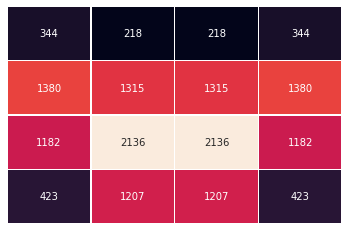

In [15]:
#dataset=[[1,1,0],[2,2,0],[1,2,1],[1,2,1],[0,0,2],[1,3,3],[3,2,3],[1,2,3],[1,5,4],[5,5,5],[1,2,6],[1,2,7],[6,2,8],[1,3,9],[2,3,9],[3,3,9],[4,3,9],[5,3,9],[3,0,10],[1,3,11],[1,2,12],[3,3,13],[4,4,14],[5,3,15],[2,3,15]]
heatmap(training_data)

In [16]:
def levelling (dataset,percent):
    #percent indicates de percentage of samples we'll allow of difference 
    #between the smallest samples and all the rest
    quadrant_count=heatmap(dataset)
    a=quadrant_count[0]
    #we'll use the following cycle to find out what is the smallest number of samples we have in one quadrant
    #(doesn't matter which quadrant that is)
    for i in quadrant_count:
        if i<a:
            a=i
    max=int((percent+1)*a)
    excess=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for i in range(len(quadrant_count)):
        if quadrant_count[i]>max:
            excess[i]=quadrant_count[i]-max
        else:
            excess[i]=0
    
    b=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    for j in dataset:
        b[j[-1]]+=[j]
    for k in range(len(b)):
        for l in range(excess[k]):
            c=random.choice(b[k])
            b[k].remove(c)
    dataset=[]
    for m in b:
        dataset+=m
    random.shuffle(dataset)
    return dataset

[344,
 218,
 479,
 479,
 218,
 344,
 479,
 479,
 479,
 479,
 423,
 479,
 479,
 479,
 479,
 423]

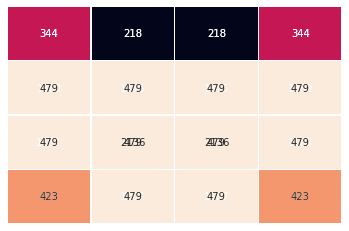

In [17]:
training_data = levelling(training_data,1.2)
heatmap(training_data)
#guardar o novo dataset em dataset, var global

[91, 55, 121, 121, 55, 91, 121, 121, 121, 121, 118, 121, 121, 121, 121, 118]

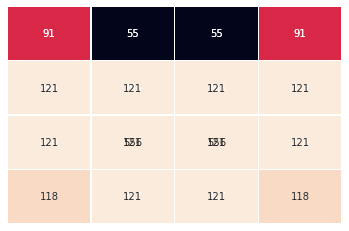

In [18]:
testing_data = levelling(testing_data,1.2)
heatmap(testing_data)

## 3. Training the models & Classifying

### 3.1 Creating a proper list of vectors

Este step is only done here in order to reduce the probability of messing up and disconecting each X vector from the correspondant Y

In [19]:
def eXifY(data):
    X, Y = [element[0:-1] for element in data], [element[-1] for element in data]
    return X, Y

In [20]:
len(eXifY(training_data)[0]) == len(eXifY(training_data)[1])

True

### 3.2 Training & Classifying

Since the goal is the comparison of the quality of the classifications according to the type of context (number of 
coordinates given), we are going to train 4 models and test them to see the differences in success rate.
Below are defined the training and testing functions, respectively.

In [21]:
def training(X,Y):
   
    nfolds=3 #3 means a 3-fold cross-validation
    Cs = [1e5,1e6,10e4] #parameter 1
    gammas = [1e-5,1e-4,1e-6] #parameter 2  
    param_grid = {'C': Cs, 'gamma' : gammas} #all in one grid
    grid_search2 = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds) #svm classifier
    grid_search2.fit(X, Y) #fitting the data
    best=grid_search2.best_params_ 

    clf = SVC(C= best['C'],gamma=best['gamma']) #creating the model with the best parameters
    clf.fit(X, Y) #fitting the model to the data

    now = datetime.datetime.now()
    timestamp = str(now.strftime("%d-%m-%Y_%Hh%Mm%Ss")) #the current day and time to have in the classifier name 
    
    datatype='0'
    #to insert in the name of the classifier and text files which of the 4 groups of coordinates is the classifier using
    if str(len(X[0])) == '10': #(head)
        datatype='Head'
    if str(len(X[0])) == '14': #(head + hands)
        datatype='Head_Hands'
    if str(len(X[0])) == '42': #(head + context data)
        datatype='Head_Context_data'
    if str(len(X[0])) == '46': #(all) 
        datatype='All'
     
    info_classif='classifier_' + timestamp + '_' + datatype +'_info.txt'
    with open(info_classif, 'w+')  as info:
        info.write('Group of Coordinates: '+ datatype + '\n')
        info.write('Type of classifier: SVM\n') # python will convert \n to os.linesep
        info.write('C:'+str(best['C'])+'\n')
        info.write('Gamma:'+str(best['gamma'])+'\n')

    
    classif = 'classifier_'+ timestamp + '_'+ datatype +'.joblib'
    dump(clf, classif) 
                       
    return classif,info_classif

In [22]:
def testing(X,Y,classif,info_classif):
    
    clf  = joblib.load(classif)
    result = clf.score(X, Y)
    
    Qpredicted= []
    i=0
    sco3=0
    sco2=0
    sco1=0
    sco0=0
    length=len(X)

    while i != length:
        Qpredicted+= [str(clf.predict(np.array([X[i]]))).strip('['+']'+'"')] #predict
        Y[i]= str(Y[i]) #converting to a string
        if Y[i]== Qpredicted[i]:
            sco3+=1
        if Y[i]== 0 & Qpredicted[i] in [1,2,3] or Y[i]== 1 & Qpredicted[i] in [0,2,3,6,4] or\
        Y[i]== 2 & Qpredicted[i] in [0,1,3,8,9] or Y[i]== 3 & Qpredicted[i] in [0,1,4,2,6,8,9,12] or\
        Y[i]== 4 & Qpredicted[i] in [1,5,3,6,7] or Y[i]== 5 & Qpredicted[i] in [4,6,7] or\
        Y[i]== 6 & Qpredicted[i] in [1,4,5,3,7,9,12,13] or Y[i]== 7 & Qpredicted[i] in [4,5,6,12,13] or\
        Y[i]== 8 & Qpredicted[i] in [2,3,9,10,11] or Y[i]== 9 & Qpredicted[i] in [2,3,6,8,12,10,11,14] or\
        Y[i]== 10 & Qpredicted[i] in [8,9,11] or Y[i]== 11 & Qpredicted[i] in [8,9,12,10,14] or\
        Y[i]== 12 & Qpredicted[i] in [3,6,7,9,13,11,15] or Y[i]== 13 & Qpredicted[i] in [6,7,12,14,15] or\
        Y[i]== 14 & Qpredicted[i] in [9,12,13,11,15] or Y[i]== 15 & Qpredicted[i] in [12,13,14]:
            sco2+=1
        if Y[i]== 0 & Qpredicted[i] in [4,6,8,9,12] or Y[i]== 1 & Qpredicted[i] in [8,9,12,13,7,5] or\
        Y[i]== 2 & Qpredicted[i] in [4,6,,12,14,10,11] or Y[i]== 3 & Qpredicted[i] in [10,11,14,15,13,7,5] or\
        Y[i]== 4 & Qpredicted[i] in [0,2,8,9,12,13] or Y[i]== 5 & Qpredicted[i] in [1,3,9,12,13] or\
        Y[i]== 6 & Qpredicted[i] in [0,2,8,10,11,14,15] or Y[i]== 7 & Qpredicted[i] in [1,3,9,11,14,15] or\
        Y[i]== 8 & Qpredicted[i] in [0,1,4,6,12,14] or Y[i]== 9 & Qpredicted[i] in [0,1,4,5,7,13,15] or\
        Y[i]== 10 & Qpredicted[i] in [2,3,6,12,14] or Y[i]== 11 & Qpredicted[i] in [2,3,6,7,13,15] or\
        Y[i]== 12 & Qpredicted[i] in [10,8,2,0,1,4,5] or Y[i]== 13 & Qpredicted[i] in [1,4,5,3,9,11] or\
        Y[i]== 14 & Qpredicted[i] in [2,3,6,7,8,10] or Y[i]== 15 & Qpredicted[i] in [3,6,7,9,11]:
            sco1+=1       
        if Y[i]== 0 & Qpredicted[i] in [5,7,13,15,10,11,14] or Y[i] in [1,4] & Qpredicted[i] in [10,11,14,15] or\
        Y[i] in [2,8] & Qpredicted[i] in [5,7,13,15] or\
        Y[i]== 5 & Qpredicted[i] in [0,2,8,10,11,14,15] or\
        Y[i] in [7,13] & Qpredicted[i] in [0,2,8,10] or\
        Y[i]== 10 & Qpredicted[i] in [0,1,4,5,7,13,15] or Y[i] in [11,14] & Qpredicted[i] in [0,1,4,5] or\
        Y[i]== 15 & Qpredicted[i] in [0,2,8,10,1,4,5]:
            sco0+=1    
        i+=1
            
    rangescore= (3*sco3+2*sco2+sco1)
    rangescoreper=rangescore/len(Y)*100
    sco3per= sco3/len(Y)*100
    sco2per= sco2/len(Y)*100
    sco1per= sco1/len(Y)*100
    sco0per= sco0/len(Y)*100
        
    print('The percentage of success was: ' + str(result*100)+ ' %\n')
    print('The range score was' + str(rangescoreper) + '%:' + str(rangescore) + ' out of ' + str(len(Y)) + '\n')
    print('The score 3 was: ' + str(sco3per)+ ' %\n')
    print('The score 2 was: ' + str(sco2per)+ ' %\n')
    print('The score 1 was: ' + str(sco1per)+ ' %\n')
    print('The score 0 was: ' + str(sco0per)+ ' %\n')
    
    with open(info_classif, 'a')  as info:
        info.write('\n----\n')
        info.write('The percentage of success was: ' + str(result*100)+ ' %\n')
        
    CONF= confusion_matrix(np.array(Y), np.array(Qpredicted))
    
    labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    print(classification_report(np.array(Y), np.array(Qpredicted), labels=labels))

    return CONF, result, Qpredicted

#### 3.2.1 Using only the face keypoints

Since we're only using  the keypoints of the head, we'll delete context information about the difference short/long distance object and hands coordinates. <br> 
The head coordinates are the first 10 (5*2) (x,y).

Below we will:<br> 
 - Delete the coordinates we don't need (mentioned before) from the whole training data;<br> 
 - Train the model with only the head coordinates using the training function (defined before);<br> 
 - Delete the coordinates we don't need (mentioned before) from the whole testing data;<br> 
 - Test the model with only the head coordinates using the training function (defined before).

In [23]:
X, Y = eXifY(training_data)
X = [element[:12] + [element[-5]] for element in X]

In [24]:
classif,info_classif=training(X,Y)

In [25]:
X, Y = eXifY(testing_data)
X = [element[:12] + [element[-5]] for element in X]

In [26]:
CONF1, result, Qpredicted = testing(X,Y,classif,info_classif)
#print(Qpredicted)
#print(Y)
print(CONF1)

The percentage of success was: 71.92174913693901 %

[[73  0  1  0  1  0  1  0  7  1  0  3  0  1  1  2]
 [ 1 50  0  0  0  0  0  0  1  1  2  0  0  0  0  0]
 [ 1  0 87  3  4  2  0  0  5  0  0  0  3  1  8  4]
 [ 0  1  3 87  4  0  4  0  0  4  1  1  0  2  1 13]
 [ 0  1  0  4 75  8  5  0  1  4  2  3 11  2  3  2]
 [ 0  0  0  2  4 90  2  4  1  0  1  2  2 13  0  0]
 [ 5  1  2  6  5  0 86  5  1  2  1  2  1  1  1  2]
 [ 0  0  0  0  4  4  3 90  4  3  0  1  1  5  0  3]
 [ 3  1  2  0  2  0  1  1 85  6  2  1  2  0 11  4]
 [ 1  5  0  1  3  0  1  2  9 81  2  1  3  1  5  6]
 [ 0  4  0  0  0  0  1  0  3  0 47  0  0  0  0  0]
 [ 2  1  0  2  0  0  0  1  1  3  2 74  2  3  0  0]
 [ 1  4  1  1  2  4  1  0  2  5  4  1 89  4  1  1]
 [ 0  2  0  0  4 11  0  0  0  4  0  5  9 86  0  0]
 [ 1  1  8  2  0  0  0  0 12  3  0  1  1  2 81  9]
 [ 4  2  4  5  1  0  1  1  4 10  3  2  1  1 13 69]]


#### 3.2.2 Using only keypoints (face + hands)

Since we're only using  the keypoints of the head and the hands, we'll delete context information about the difference short/long distance object.<br> 
The keypoints (head + hands) coordinates are the first 10 (5*2) + 4 (2*2)(x,y), giving a total of 14.<br> 
The rest of the procedure is the same as in 3.2.1.:

Below we will:<br> 
 - Delete the coordinates we don't need (mentioned before) from the whole training data;<br> 
 - Train the model with only the head + hand coordinates using the training function (defined before);<br> 
 - Delete the coordinates we don't need (mentioned before) from the whole testing data;<br> 
 - Test the model with only the head + hand coordinates using the training function (defined before).

In [27]:
X, Y = eXifY(training_data)
X = [element[:16] + element[-5:] for element in X]

In [28]:
classif,info_classif=training(X,Y)

In [29]:
X, Y = eXifY(testing_data)
X = [element[:16] + element[-5:] for element in X]

In [30]:
CONF2, result, Qpredicted = testing(X,Y,classif,info_classif)
#print(Qpredicted)
#print(Y)
print(CONF2)

The percentage of success was: 77.79056386651322 %

[[ 81   0   0   0   1   0   0   0   3   2   0   1   0   0   0   3]
 [  4  45   0   0   0   0   0   1   0   2   2   0   0   0   0   1]
 [  1   0 101   1   3   0   0   0   1   0   1   0   1   0   8   1]
 [  0   0   3  92   3   2   3   0   0   4   0   0   0   2   2  10]
 [  1   0   1   0  85   7   6   1   2   4   0   1   4   4   2   3]
 [  0   0   0   1   1  92   3   4   1   0   1   0   1  15   2   0]
 [  0   1   0   7   6   1  92   5   1   1   0   0   2   1   0   4]
 [  0   1   0   0   0   6   3 104   0   0   1   1   0   1   0   1]
 [  6   2   1   0   1   0   2   1  85  10   1   1   2   0   7   2]
 [  1   0   1   2   0   1   1   0   6  95   0   0   4   4   2   4]
 [  0   1   0   0   1   0   1   0   0   1  46   1   0   2   1   1]
 [  1   2   0   0   1   1   0   0   0   1   0  78   1   3   1   2]
 [  2   1   0   0   4   3   0   0   2   9   5   0  88   6   0   1]
 [  0   1   0   0   1   9   0   1   0   1   0   3   6  98   0   1]
 [  1   1 

#### 3.2.3 Using only the keypoints of the head and context data

Since we're only using  the keypoints of the head and the context information about the difference short/long distance object, we'll delete the hand coordinates.<br> 
The keypoints of the head coordinates are the first 10 (5*2) and the context data goes from the 15 to the 46 coordinates (but on the code we have to do it from 14th to start on the 15th) giving a total of 42 coordinates.<br>
The rest of the procedure is the same as in 3.2.1.:

Below we will:<br>
 - Delete the coordinates we don't need (mentioned before) from the whole training data;<br>
 - Train the model with only the head + context data coordinates using the training function (defined before);<br>
 - Delete the coordinates we don't need (mentioned before) from the whole testing data;<br>
 - Test the model with only the head + context data coordinates using the training function (defined before).

In [31]:
X, Y = eXifY(training_data)
X = [element[:12] + element[16:-5] for element in X]

In [32]:
classif,info_classif=training(X,Y)

In [33]:
X, Y = eXifY(testing_data)
X = [element[:12] + element[16:-5] for element in X]

In [34]:
CONF3, result, Qpredicted = testing(X,Y,classif,info_classif)
#print(Qpredicted)
#print(Y)
print(CONF3)

The percentage of success was: 83.3716915995397 %

[[ 82   1   0   0   0   0   0   0   5   1   0   0   0   0   0   2]
 [  0  44   0   0   0   0   1   0   1   4   1   2   0   1   1   0]
 [  0   0 108   1   1   0   0   0   2   0   1   0   0   1   4   0]
 [  0   1   3 102   0   2   2   1   0   0   2   1   1   0   2   4]
 [  1   1   1   3  94   1   5   1   2   5   0   0   2   1   1   3]
 [  0   0   1   1   4 101   2   3   0   1   0   0   2   4   1   1]
 [  3   0   0   3   4   0 103   1   2   1   0   1   1   1   1   0]
 [  0   0   0   0   1   2   3 106   0   0   1   1   1   2   0   1]
 [  3   3   0   0   0   1   0   0 105   3   2   0   0   1   2   1]
 [  3   4   0   1   1   0   0   1   2  98   2   1   3   2   0   3]
 [  1   3   0   1   0   0   2   0   0   0  45   1   1   1   0   0]
 [  0   1   0   0   0   0   0   0   1   6   0  79   1   3   0   0]
 [  2   1   0   0   2   0   0   1   4   6   5   0  95   5   0   0]
 [  0   2   0   0   2   2   0   1   0   3   5   2   5  99   0   0]
 [  1   0  

#### 3.2.4 Using all the coordinates (keypoints of the head, hands and context data)

Now we are using the whole set of coordinates (keypoints of the head, hands and context data) giving a total of 46 coordinates.

Below we will:<br>
 - Create the training data divided into X (coordinates) and Y (quadrants) like before;<br>
 - Train the model with all the 46 coordinates using the training function (defined before);<br>
 - Create the test data divided into X (coordinates) and Y (quadrants) like before; <br>
 - Test the model with all the coordinates using the training function (defined before).

In [35]:
X, Y = eXifY(training_data)

In [36]:
len(X)

6760

In [37]:
len(Y)

6760

In [38]:
classif,info_classif=training(X,Y)

In [39]:
X, Y = eXifY(testing_data)

In [40]:
len(X[0])

53

In [41]:
CONF4, result, Qpredicted = testing(X,Y,classif,info_classif)
#print(Qpredicted)
#print(Y)
print(CONF4)

The percentage of success was: 81.81818181818183 %

[[ 82   0   0   0   1   0   0   0   3   3   0   0   0   0   0   2]
 [  3  44   0   0   0   0   0   0   0   1   3   2   1   0   1   0]
 [  0   0 105   1   1   0   0   0   2   1   0   0   0   1   7   0]
 [  2   0   2  93   2   1   4   1   1   1   0   0   1   1   2  10]
 [  0   1   0   2  97   3   3   0   0   2   0   0   5   5   3   0]
 [  0   0   1   3   2  99   1   4   0   1   0   0   2   7   1   0]
 [  1   1   0   5   3   0  98   3   0   3   0   0   0   2   2   3]
 [  0   0   0   0   0   4   2 106   0   1   0   1   0   3   0   1]
 [  5   1   0   0   0   0   2   0  99   5   1   0   2   1   3   2]
 [  1   1   0   1   0   0   1   2   6  96   1   0   6   2   1   3]
 [  0   3   0   0   0   1   1   0   2   2  42   1   2   1   0   0]
 [  1   1   0   1   1   0   0   0   0   2   1  76   3   3   0   2]
 [  1   1   1   0   2   1   0   0   4   7   4   1  94   5   0   0]
 [  0   1   0   0   0   4   0   0   0   2   3   4   6 101   0   0]
 [  0   0 

## 4. Comparing classifications

Now, at last, we compare the Confusion Matrices of the 4 groups of coordinates. And with a nice layout!

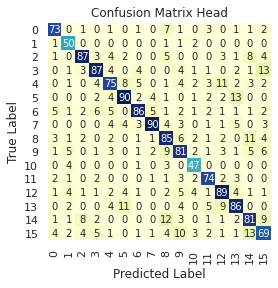

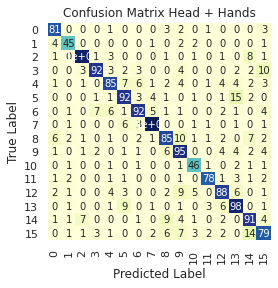

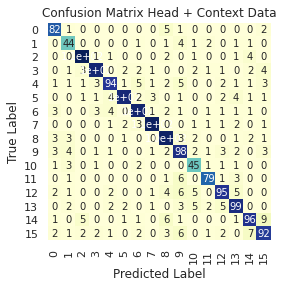

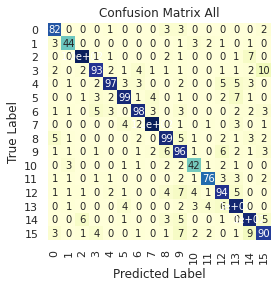

In [43]:
plt.figure()  
plt.rcParams["figure.figsize"] = (4,4)
df = DataFrame(CONF1) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix Head')
plt.show()

plt.figure() 
plt.rcParams["figure.figsize"] = (4,4)
df = DataFrame(CONF2) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix Head + Hands')
plt.show()

plt.figure()
plt.rcParams["figure.figsize"] = (4,4)
df = DataFrame(CONF3) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix Head + Context Data')
plt.show()

plt.figure()
plt.rcParams["figure.figsize"] = (4,4)
df = DataFrame(CONF4) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix All')
#plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show()